In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Load the logistic regression dataset
df_log_reg = pd.read_csv("../../Data and data related codes/dataset_log_reg.csv")
df_log_reg['Date'] = pd.to_datetime(df_log_reg['Date'], errors='coerce')

# Filter for the last 2 months
end_date_log = df_log_reg['Date'].max()
start_date_log = end_date_log - pd.DateOffset(months=2)
df_last_2_months_log = df_log_reg[(df_log_reg['Date'] >= start_date_log) & (df_log_reg['Date'] <= end_date_log)]

# Prepare features (X) and target (y)
X_log = df_last_2_months_log.drop(columns=['Date', 'F_Close_pred_class'])  # Exclude Date and target
y_log = df_last_2_months_log['F_Close_pred_class']

# Step 1: Split data - keep the last 3 days as an unseen test set
split_index_log = len(X_log) - 3
X_train_val_log, X_unseen_test_log = X_log[:split_index_log], X_log[split_index_log:]
y_train_val_log, y_unseen_test_log = y_log[:split_index_log], y_log[split_index_log:]

Grid Search Results with Accuracy for Logistic Regression:
                Model                                    Best Parameters  \
0  LogisticRegression  {'C': 10.0, 'penalty': 'l1', 'solver': 'liblin...   

   Best Accuracy  
0       0.633333  
Best model: LogisticRegression(C=10.0, penalty='l1', solver='liblinear'), Accuracy: 0.6333333333333333
Unseen Test Accuracy: 0.3333333333333333
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.33      1.00      0.50         1

    accuracy                           0.33         3
   macro avg       0.17      0.50      0.25         3
weighted avg       0.11      0.33      0.17         3



/Applications/anaconda3/envs/equity_vs_commodity/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/anaconda3/envs/equity_vs_commodity/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/anaconda3/envs/equity_vs_commodity/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

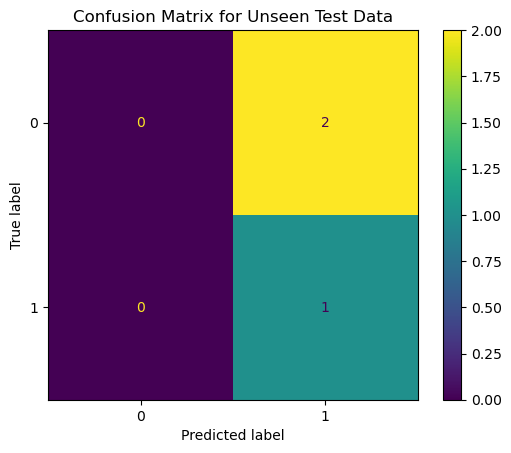

In [2]:
# Step 2: Preprocess the data (fit on training set, transform both sets)
scaler_log = StandardScaler()
power_transformer_log = PowerTransformer()

# Fit and transform the training data
X_train_val_log_scaled = scaler_log.fit_transform(X_train_val_log)
X_train_val_log_transformed = power_transformer_log.fit_transform(X_train_val_log_scaled)

# Only transform the unseen test data
X_unseen_test_log_scaled = scaler_log.transform(X_unseen_test_log)
X_unseen_test_log_transformed = power_transformer_log.transform(X_unseen_test_log_scaled)

# Step 3: Set up parameter grid for Logistic Regression with different regularizations
log_params = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Regularization type (L1 for Lasso, L2 for Ridge)
    'solver': ['liblinear']  # Required solver for 'l1' penalty
}

# Initialize Logistic Regression model
log_model = LogisticRegression()

# TimeSeriesSplit for cross-validation
tscv_log = TimeSeriesSplit(n_splits=5)

# GridSearchCV with TimeSeriesSplit for logistic regression
log_cv = GridSearchCV(log_model, log_params, scoring='accuracy', cv=tscv_log)

# Fit model on training and validation set
log_cv.fit(X_train_val_log_transformed, y_train_val_log)

# Step 4: Collect accuracy and best parameters in a table
results_log = pd.DataFrame({
    'Model': ['LogisticRegression'],
    'Best Parameters': [log_cv.best_params_],
    'Best Accuracy': [log_cv.best_score_]
})

# Display the table
print("Grid Search Results with Accuracy for Logistic Regression:")
print(results_log)

# Choose the best model based on the highest accuracy
best_log_model = log_cv.best_estimator_
print(f"Best model: {best_log_model}, Accuracy: {log_cv.best_score_}")

# Step 5: Evaluate the best model on the unseen test set
y_unseen_pred_log = best_log_model.predict(X_unseen_test_log_transformed)
test_accuracy = accuracy_score(y_unseen_test_log, y_unseen_pred_log)

print(f"Unseen Test Accuracy: {test_accuracy}")
print(classification_report(y_unseen_test_log, y_unseen_pred_log))

# Optional: Visualize the confusion matrix
ConfusionMatrixDisplay.from_estimator(best_log_model, X_unseen_test_log_transformed, y_unseen_test_log)
plt.title("Confusion Matrix for Unseen Test Data")
plt.show()

Best Logistic Regression Model: LogisticRegression(C=10, penalty='l1', solver='liblinear'), Accuracy: 0.6333333333333333
Unseen Test Accuracy (3 days): 0.3333333333333333
Classification Report for Unseen Test Set (3 Days):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.33      1.00      0.50         1

    accuracy                           0.33         3
   macro avg       0.17      0.50      0.25         3
weighted avg       0.11      0.33      0.17         3



/Applications/anaconda3/envs/equity_vs_commodity/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/anaconda3/envs/equity_vs_commodity/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/anaconda3/envs/equity_vs_commodity/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

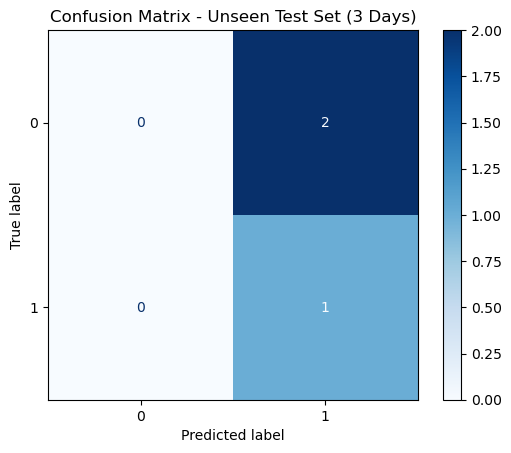

Future Predictions (Next 3 Days): [1 1 1]


In [3]:
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, PowerTransformer
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Prepare train-test split - keep the last 3 days as an unseen test set
split_index_log = len(X_log) - 3
X_train_val_log, X_unseen_test_log = X_log[:split_index_log], X_log[split_index_log:]
y_train_val_log, y_unseen_test_log = y_log[:split_index_log], y_log[split_index_log:]

# Step 2: Preprocess data - Fit scaler and transformer on training data, then transform test data
scaler = StandardScaler()
power_transformer = PowerTransformer()

# Fit and transform the training data
X_train_val_log_scaled = scaler.fit_transform(X_train_val_log)
X_train_val_log_transformed = power_transformer.fit_transform(X_train_val_log_scaled)

# Transform the unseen test data
X_unseen_test_log_scaled = scaler.transform(X_unseen_test_log)
X_unseen_test_log_transformed = power_transformer.transform(X_unseen_test_log_scaled)

# Step 3: Logistic Regression parameter grid for GridSearchCV
log_params = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}

# Set up cross-validation with TimeSeriesSplit
tscv_log = TimeSeriesSplit(n_splits=5)

# Initialize and fit logistic regression model with GridSearchCV
log_reg = LogisticRegression()
log_cv = GridSearchCV(log_reg, log_params, cv=tscv_log, scoring='accuracy')
log_cv.fit(X_train_val_log_transformed, y_train_val_log)

# Get the best model from cross-validation
best_log_model = log_cv.best_estimator_
best_accuracy = log_cv.best_score_
print(f"Best Logistic Regression Model: {best_log_model}, Accuracy: {best_accuracy}")

# Step 4: Predict on the unseen test set (last 3 days)
y_unseen_pred_log = best_log_model.predict(X_unseen_test_log_transformed)
unseen_test_accuracy = accuracy_score(y_unseen_test_log, y_unseen_pred_log)
print(f"Unseen Test Accuracy (3 days): {unseen_test_accuracy}")

# Display classification report for unseen test predictions
print("Classification Report for Unseen Test Set (3 Days):")
print(classification_report(y_unseen_test_log, y_unseen_pred_log))

# Step 5: Forecast next 3 days using the transformed features
future_predictions_log = best_log_model.predict(X_unseen_test_log_transformed)

# Plot results: Confusion matrix for unseen test set predictions
ConfusionMatrixDisplay.from_predictions(y_unseen_test_log, y_unseen_pred_log, cmap='Blues')
plt.title("Confusion Matrix - Unseen Test Set (3 Days)")
plt.show()

# Print predictions for future data
print(f"Future Predictions (Next 3 Days): {future_predictions_log}")

Unseen Test Accuracy (3 days): 0.3333333333333333


/Applications/anaconda3/envs/equity_vs_commodity/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Applications/anaconda3/envs/equity_vs_commodity/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


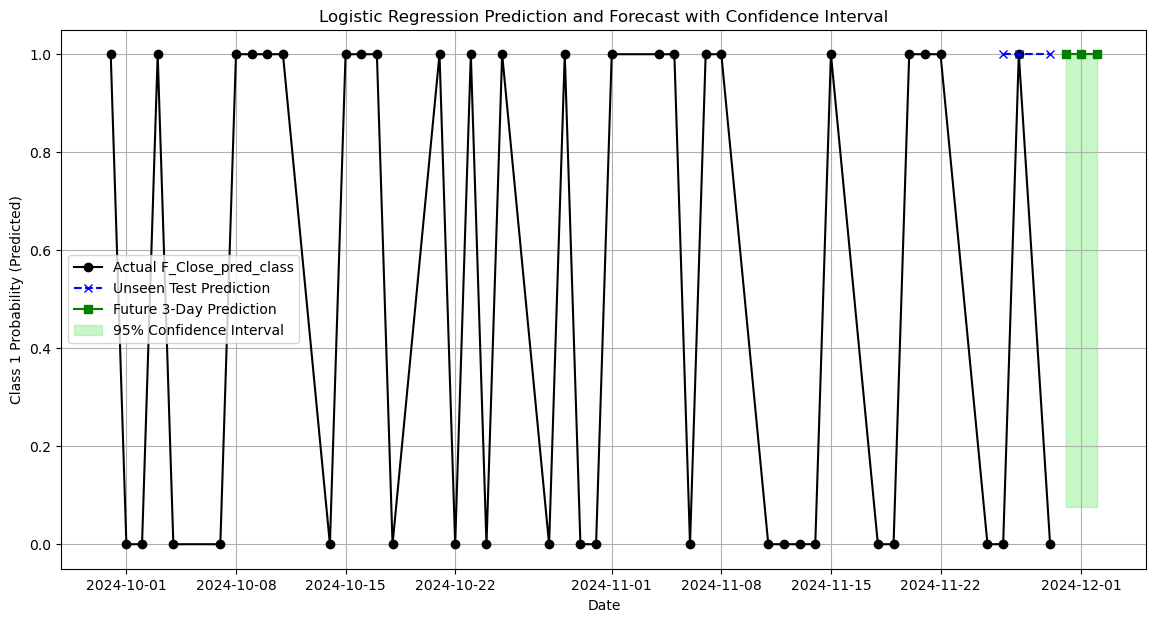

In [4]:
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Step 6: Predict on the unseen test data (last 3 days)
y_unseen_pred_log = best_log_model.predict(X_unseen_test_log)
unseen_test_accuracy = accuracy_score(y_unseen_test_log, y_unseen_pred_log)
print(f"Unseen Test Accuracy (3 days): {unseen_test_accuracy}")

# Step 7: Forecast the next 3 days using the best model
# Ensure future data is properly scaled and transformed
future_3_days_log = X_log[-3:]  # Use the last 3 rows of raw data
future_3_days_scaled = scaler.transform(future_3_days_log)
future_3_days_transformed = power_transformer.transform(future_3_days_scaled)

# Predict future class probabilities
future_predictions_log = best_log_model.predict(future_3_days_transformed)

# Calculate confidence intervals for class probabilities
y_unseen_pred_prob = best_log_model.predict_proba(X_unseen_test_log)[:, 1]  # Probabilities for class 1
std_dev_log = np.std(y_unseen_pred_prob - y_unseen_test_log)  # Standard deviation of residuals

# Predict probabilities for the next 3 days
future_pred_prob = best_log_model.predict_proba(future_3_days_transformed)[:, 1]
upper_bound_log = np.clip(future_pred_prob + (1.96 * std_dev_log), 0, 1)  # Clip bounds to [0, 1]
lower_bound_log = np.clip(future_pred_prob - (1.96 * std_dev_log), 0, 1)

# Step 8: Plot results with confidence intervals
plt.figure(figsize=(14, 7))

# Plot actual class labels for the last 2 months
plt.plot(df_last_2_months_log['Date'], y_log, label="Actual F_Close_pred_class", color='black', linestyle='-', marker='o')

# Plot predictions for the last 3 unseen test days
plt.plot(df_last_2_months_log['Date'].iloc[-3:], y_unseen_pred_log, label="Unseen Test Prediction", color='blue', linestyle='--', marker='x')

# Plot predictions for the next 3 forecasted days
future_dates_log = pd.date_range(df_last_2_months_log['Date'].iloc[-1] + pd.Timedelta(days=1), periods=3)
plt.plot(future_dates_log, future_predictions_log, label="Future 3-Day Prediction", color='green', linestyle='-', marker='s')

# Confidence intervals for future predictions
plt.fill_between(future_dates_log, lower_bound_log, upper_bound_log, color='lightgreen', alpha=0.5, label="95% Confidence Interval")

# Plot formatting
plt.xlabel("Date")
plt.ylabel("Class 1 Probability (Predicted)")
plt.title("Logistic Regression Prediction and Forecast with Confidence Interval")
plt.legend()
plt.grid(True)
plt.show()

In [5]:
# Create a DataFrame to compare actual values and predicted values for the last ten days

# Step 1: Extract dates for the last ten days
dates_last_ten_days = df_last_2_months_log['Date'].iloc[-10:].values

# Step 2: Extract actual values for the last ten days
actual_values_last_ten_days = y_log.iloc[-10:].values

# Step 3: Initialize predicted values with NaN for the first 7 days and predictions for the last 3 days
predicted_values_last_ten_days = [np.nan] * 7 + list(y_unseen_pred_log)

# Step 4: Create a DataFrame with actual and predicted values
comparison_df = pd.DataFrame({
    'Date': dates_last_ten_days,
    'Actual F_Close_pred_class': actual_values_last_ten_days,
    'Predicted F_Close_pred_class': predicted_values_last_ten_days
})

# Step 5: Reset the index for a cleaner display
comparison_df.reset_index(drop=True, inplace=True)

# Display the comparison DataFrame
print(comparison_df)

        Date  Actual F_Close_pred_class  Predicted F_Close_pred_class
0 2024-11-15                          1                           NaN
1 2024-11-18                          0                           NaN
2 2024-11-19                          0                           NaN
3 2024-11-20                          1                           NaN
4 2024-11-21                          1                           NaN
5 2024-11-22                          1                           NaN
6 2024-11-25                          0                           NaN
7 2024-11-26                          0                           1.0
8 2024-11-27                          1                           1.0
9 2024-11-29                          0                           1.0


In [25]:
# Assuming `comparison_df` and `future_predictions` are already defined

# Generate future dates for the forecasted 7 days
future_dates = pd.date_range(comparison_df['Date'].iloc[-1] + pd.Timedelta(days=1), periods=3)

# Create a DataFrame for the forecasted data with NaN for actual values and predictions in predicted column
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Actual F_Close_pred': [np.nan] * 3,  # No actual data for the future
    'Predicted F_Close_pred': future_predictions_log  # Forecasted predictions
})

# Append the forecasted data to the original comparison_df
comparison_df_with_forecast = pd.concat([comparison_df, forecast_df], ignore_index=True)

# Display the updated table with both the last week's predictions and the future forecast
print(comparison_df_with_forecast)

         Date  Actual F_Close_pred  Predicted F_Close_pred
0  2024-11-14                  0.0                     NaN
1  2024-11-15                  1.0                     NaN
2  2024-11-18                  0.0                     NaN
3  2024-11-19                  0.0                     NaN
4  2024-11-20                  1.0                     NaN
5  2024-11-21                  1.0                     NaN
6  2024-11-22                  1.0                     NaN
7  2024-11-25                  0.0                     1.0
8  2024-11-26                  0.0                     1.0
9  2024-11-27                  0.0                     1.0
10 2024-11-28                  NaN                     1.0
11 2024-11-29                  NaN                     1.0
12 2024-11-30                  NaN                     1.0
